In [1]:
from __future__ import print_function
from PIL import Image
from grpc.beta import implementations
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
import requests,os
import numpy as np
from io import StringIO
from keras.preprocessing.image import load_img
#tf.enable_eager_execution() 

Using TensorFlow backend.


In [7]:
server = 'localhost:9000'
host, port = server.split(':')

In [26]:
!ls "/home/habib/Documents/samples/"
fl_type = "tulip"
sample_num = '2'
new_sample = "/home/habib/Documents/samples/"+fl_type+"_sample"+sample_num+".jpg"
new_sample

daisy_sample1.jpg      roses_sample1.jpg       sunflowers_sample3.jpg
daisy_sample2.jpg      roses_sample2.jpg       tulip_sample1.jpg
dandelion_sample1.jpg  roses_sample3.jpg       tulip_sample2.jpg
dandelion_sample2.jpg  sunflowers_sample1.jpg  tulip_sample3.jpg
dandelion_sample3.jpg  sunflowers_sample2.jpg


'/home/habib/Documents/samples/tulip_sample2.jpg'

In [8]:
filename = new_sample
image = np.array(load_img(os.path.realpath(filename)))              
#x=img_to_array(img) 
print("Image shape:", image.shape)

Image shape: (240, 320, 3)


In [9]:
image[1:10,1:10,1]

array([[ 74, 122,  63,  43,  31,  50,  74,  90,  74],
       [ 46,  84, 130, 122,  26,  41,  38,  66,  52],
       [ 19,  64, 117, 132,  73,  12,  43,  89, 117],
       [120, 114, 112, 153, 176,  22,  73, 116, 100],
       [ 94, 123,  98,  78,  70, 198,  97,  80,  79],
       [116, 134, 108, 103,  93, 114,  45,  44, 125],
       [131,  40,  58,  79,  93, 143, 129, 135, 122],
       [ 56,  84,  95,  82,  70, 124,  81,  52,  78],
       [ 66, 100,  71,  78, 109, 109, 101,  50,  89]], dtype=uint8)

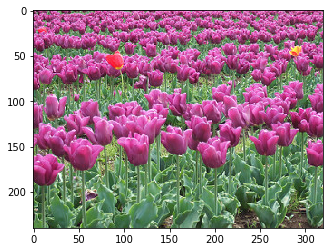

In [10]:
plt.imshow(image)
plt.show()

In [11]:
X = tf.placeholder(tf.int32,[image.shape[0],image.shape[1],3])

input_shape = tf.shape(X)[0:2]
input_shape_float = tf.to_float(input_shape)
#scale = tf.random_uniform(shape=[1],
#                                 minval=1,
#                                 maxval=1)
scale_h = tf.div(64.0,input_shape_float[0])
scale_w = tf.div(64.0,input_shape_float[1])
print(scale_h)
print(scale_w)

Tensor("div:0", shape=(), dtype=float32)
Tensor("div_1:0", shape=(), dtype=float32)


In [12]:
scaled_input_shape = tf.to_int32([tf.round(input_shape_float[0] * scale_h), tf.round(input_shape_float[1] * scale_w)]) 
image_scaled = tf.image.resize_images(X, scaled_input_shape,
method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

In [13]:
sess = tf.Session()
image = sess.run(image_scaled,feed_dict={X:image})
print(image.shape)
image[1:10,1:10,1]

(64, 64, 3)


array([[ 73, 146,  84,  36,  97, 141,  55,  55, 121],
       [ 93,  50, 104,  81,  79,  92,  94,  80,  72],
       [ 94,  79,  23,  90,  62,  83,  44,  51,  82],
       [ 58,  96,  88, 113,  97, 111, 160,  35, 145],
       [ 17, 126,  71,  90,  87,  40,  75, 132,  57],
       [ 45,  51,  64,  88,  42,  92,  70, 103,  30],
       [133, 109,  87, 128, 125, 121, 178, 137, 137],
       [121, 111, 120, 104, 110,  88, 149, 160,  73],
       [129, 114,  34,  58,  70,  86,  99,  64,  85]], dtype=int32)

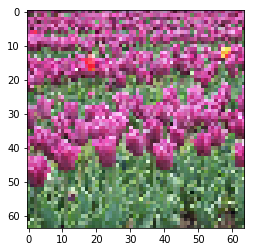

In [14]:
plt.imshow(image)
plt.show()

In [15]:
height = image.shape[0]
width = image.shape[1]
print(height)

64


In [16]:
# create the RPC stub
channel = implementations.insecure_channel(host, int(port))
#stub = prediction_service_pb2.beta_create_PredictionService_stub(channel)
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel._channel)

In [34]:
# create the request object and set the name and signature_name params
request = predict_pb2.PredictRequest()
request.model_spec.name = 'Flowers'
request.model_spec.signature_name = 'prediction'

In [35]:
# fill in the request object with the necessary data
request.inputs['examples'].CopyFrom(
  tf.contrib.util.make_tensor_proto(np.array([new_sample])))

In [36]:
# sync requests
result_future = stub.Predict(request, 30.)

_Rendezvous: <_Rendezvous of RPC that terminated with (StatusCode.INVALID_ARGUMENT, Could not parse example input, value: '/home/habib/Documents/samples/tulip_sample2.jpg'
	 [[Node: ParseExample/ParseExample = ParseExample[Ndense=1, Nsparse=0, Tdense=[DT_FLOAT], _output_shapes=[[?]], dense_shapes=[[]], sparse_types=[], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_input_example_tensor_0_0, ParseExample/ParseExample/names, ParseExample/ParseExample/dense_keys_0, ParseExample/Const)]])>

In [15]:
#print(result_future)
for pred in result_future.outputs:
    print(pred)
print(tf.make_ndarray(result_future.outputs["prediction_ind"]))
print(tf.make_ndarray(result_future.outputs["prediction_prob"]))
print(tf.make_ndarray(result_future.outputs["prediction_cls"]))

[[2 3 0 1]]
[[7.6752943e-01 2.3247056e-01 7.3242879e-17 3.5009344e-23]]
[b'caucasien' b'kerion' b'sain' b'teigne']
